In [1]:
from core.transformers import Swin_Unet
import tensorflow as tf
import numpy as np
import cv2
from core import blocks
from core.metrics import BinaryIoU, FScore, MeanIoU

In [2]:
model = Swin_Unet(
    (256, 256, 3),
    classes=1,
    patch_size=(2, 2),
    embed_dim=32,
    window_size=8,
    depths=[2, 2, 2, 4, 2],
    num_heads=[3, 6, 12, 12, 24],
)


In [3]:
model.summary()

Model: "swin_tiny_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 patch_embed (PatchEmbed)       (None, 16384, 32)    480         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 16384, 32)    0           ['patch_embed[0][0]']            
                                                                                                  
 stage_0_block_0 (SwinTransform  (None, 16384, 32)   17475       ['dropout[0][0]']    

In [4]:
cloned = tf.keras.models.clone_model(model)

### Verify that metrics are consistent

((-0.5, 255.5, 255.5, -0.5), (-0.5, 255.5, 255.5, -0.5))

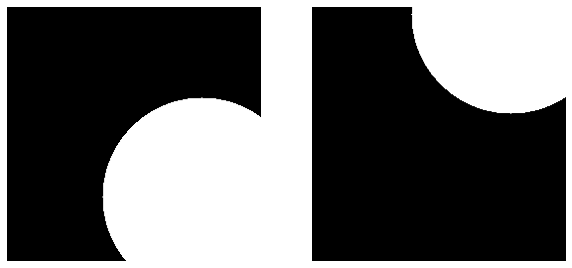

In [25]:
import matplotlib.pyplot as plt


x = np.zeros(shape=(256, 256, 1), dtype=np.float32)
y = np.zeros(shape=(256, 256, 1), dtype=np.float32)

coords_x = np.random.randint(low=0, high=256, size=2)
coords_y = np.random.randint(low=0, high=256, size=2)

cv2.circle(x, coords_x, radius=100, color=1, thickness=-1)
cv2.circle(y, coords_y, radius=100, color=1, thickness=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(x, cmap='gray')
ax2.imshow(y, cmap='gray')
ax1.axis('off'), ax2.axis('off')

In [19]:
x = np.expand_dims(x, axis=0)
y = np.expand_dims(y, axis=0)

tf_iou = tf.keras.metrics.BinaryIoU(target_class_ids=[1])
tf_iou.update_state(x, y)

my_iou = BinaryIoU(threshold=0.5)
my_iou.update_state(x, y)

np.testing.assert_allclose(tf_iou.result(), my_iou.result())

In [20]:
tf_iou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1])
tf_iou.update_state(x, y)

my_iou = MeanIoU(classes=2, threshold=0.5, sparse_y_true=True, sparse_y_pred=True)
my_iou.update_state(x, y)

np.testing.assert_allclose(tf_iou.result(), my_iou.result())

In [27]:
from sklearn.metrics import f1_score

my_f1 = FScore()
my_f1.update_state(x, y)

sk_f1 = f1_score(x.ravel(), y.ravel())

np.testing.assert_allclose(sk_f1, my_f1.result())